In [232]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [233]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
        elif label[0] == 'linear_cost':
            label = 'Compute-Wait'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1:
            color = 'tab:blue'
            temp=True
        elif row['waiting_policy_x'] == 'linear_runtime' and row['waiting_factor_x'] == 1.25:
            color = 'tab:red'
            temp=True
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08:
            color = 'tab:green'
            temp=True
        elif row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 1:
            color = 'tab:orange'
            temp=True
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker="*", markersize=14, markeredgecolor='black', markerfacecolor=color)
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_policy_pareto.pdf', bbox_inches='tight')
    plt.show()  

In [107]:

philly_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/pareto.log')

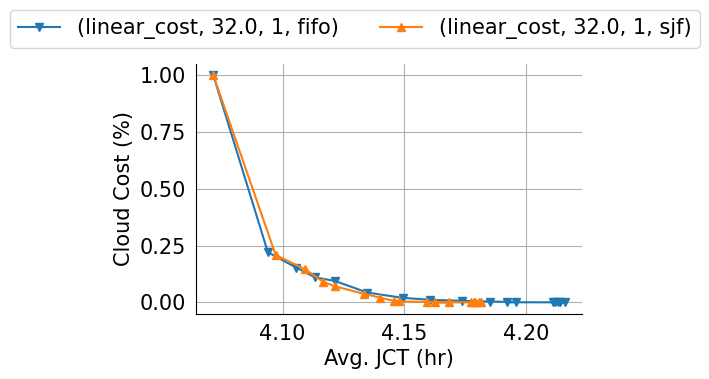

In [115]:
lol_df = philly_df[philly_df['waiting_policy']=='linear_cost']
lol_df = lol_df[lol_df['loop']==1]

simulator_plotting_fn(lol_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1, 'sched_alg': 'fifo'},
                      groupby_values=['waiting_policy', 'arrival_rate', 'loop', 'sched_alg'],
                      normalize_x_axis=True)


# simulator_plotting_fn(lol_df, x_axis='avg_jct',  \
#                       y_axis=['norm_cloud_cost'], \
#                       baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, 'loop': 0, 'sched_alg': 'fifo'},
#                       groupby_values=['waiting_policy', 'arrival_rate', 'loop', 'sched_alg'],
#                       normalize_x_axis=True)

In [163]:
philly_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/philly_pareto.log')

Constant-Wait
Starburst
0     0.876938
1     0.876927
2     0.876917
3     0.876886
4     0.876760
5     0.876707
6     0.876509
7     0.876400
8     0.875491
9     0.873805
10    0.870109
11    0.863262
12    0.849954
13    0.833732
14    0.833732
15    0.833732
16    0.876938
17    0.876610
18    0.876475
19    0.876429
20    0.876350
21    0.876249
22    0.876125
23    0.876201
24    0.876207
25    0.876081
26    0.876040
27    0.875908
28    0.875884
29    0.876105
30    0.876069
31    0.875971
32    0.876033
33    0.876043
34    0.875949
Name: system_utilization_x, dtype: float64
0     0.876938
1     0.876927
2     0.876917
3     0.876886
4     0.876760
5     0.876707
6     0.876509
7     0.876400
8     0.875491
9     0.873805
10    0.870109
11    0.863262
12    0.849954
13    0.833732
14    0.833732
15    0.833732
16    0.876938
17    0.876610
18    0.876475
19    0.876429
20    0.876350
21    0.876249
22    0.876125
23    0.876201
24    0.876207
25    0.876081
26    0.876040
27 

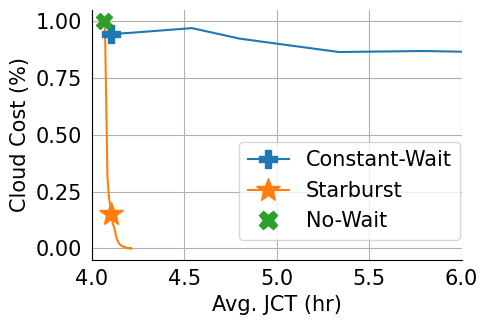

In [246]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=4, right=6)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)

        if label[0] == 'constant':
            if label[1] == 1:
                continue
            label = 'Constant-Wait'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
        print(label)
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    print(diff_df['system_utilization_x'])
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    print(diff_df['system_utilization_x'])
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1:
            color = 'tab:blue'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08:
            color = 'tab:orange'
            temp=True
            marker = '*'
            marker_size = 18
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(4.065, 1, marker="X", markersize=12, markeredgecolor='tab:green', markerfacecolor='tab:green', label='No-Wait')
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='Constant-Wait'), \
             Line2D([0], [0], marker='*', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=18, markeredgecolor='tab:orange', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:green', \
            markersize=13, markeredgecolor='tab:green', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.94, 0.25))
    
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly_pareto.pdf', bbox_inches='tight')
    plt.show()
    
    
simulator_plotting_fn(philly_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)

In [179]:
helios_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/helios_pareto.log')

Constant-Wait
Starburst
0     0.768998
1     0.768995
2     0.768991
3     0.768985
4     0.768968
5     0.768967
6     0.768856
7     0.768894
8     0.768542
9     0.768475
10    0.768234
11    0.768327
12    0.768998
13    0.768995
14    0.768995
15    0.768995
16    0.768993
17    0.768993
18    0.768995
19    0.768987
20    0.768985
21    0.768992
22    0.768994
23    0.768800
24    0.768797
25    0.768783
26    0.768782
27    0.768742
28    0.768742
29    0.768740
30    0.768740
31    0.768740
Name: system_utilization_x, dtype: float64
['Constant-Wait', 'Starburst', 'No-Wait']


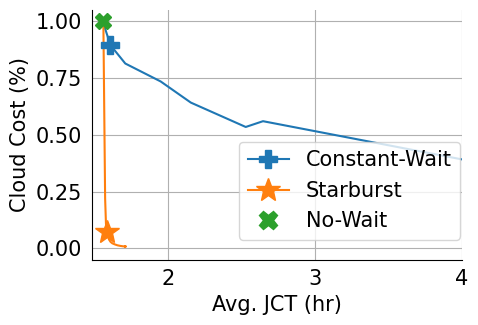

In [248]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)

        if label[0] == 'constant':
            if label[1] == 1:
                continue
            label = 'Constant-Wait'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
        print(label)
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    print(diff_df['system_utilization_x'])
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1:
            color = 'tab:blue'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'linear_cost_filter_cpu' and row['waiting_factor_x'] == 0.08:
            color = 'tab:orange'
            temp=True
            marker = '*'
            marker_size = 18
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(1.56, 1, marker="X", markersize=12, markeredgecolor='tab:green', markerfacecolor='tab:green', label='No-Wait')
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='Constant-Wait'), \
             Line2D([0], [0], marker='*', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=18, markeredgecolor='tab:orange', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:green', \
            markersize=13, markeredgecolor='tab:green', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.94, 0.25))
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_pareto.pdf', bbox_inches='tight')
    plt.show()
    
    
simulator_plotting_fn(helios_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)

In [269]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
        elif label[0] == 'linear_cost':
            label = 'Compute-Wait'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1:
            color = 'tab:blue'
            marker = 'P'
            marker_size = 13
            temp=True
        elif row['waiting_policy_x'] == 'linear_runtime' and row['waiting_factor_x'] == 1.25:
            color = 'tab:red'
            marker = 'X'
            marker_size = 13
            temp=True
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08:
            color = 'tab:green'
            marker = '*'
            marker_size = 18
            temp=True
        elif row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 1:
            color = 'tab:orange'
            marker = 'o'
            marker_size = 13
            temp=True
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    
    fig.legend([Line2D([0], [0], marker='P', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='Constant-Wait'), \
                Line2D([0], [0], marker='o', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='Resource-Wait'), \
                 Line2D([0], [0], marker='*', color='tab:green', markerfacecolor='tab:green', \
            markersize=18, markeredgecolor='tab:green', label='Compute-Wait'), \
                Line2D([0], [0], marker='X', color='tab:red', markerfacecolor='tab:red', \
            markersize=13, markeredgecolor='tab:red', label='Runtime-Wait')], \
               labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_policy_pareto.pdf', bbox_inches='tight')
    plt.show()  

In [209]:

asdf_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/pareto_waiting_policies.log')

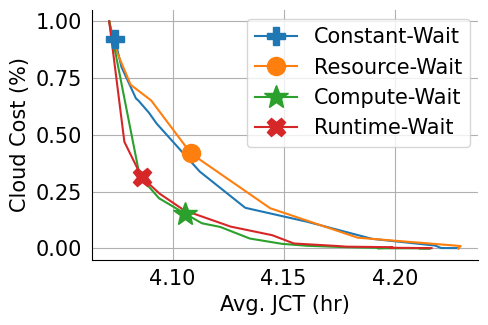

In [271]:
simulator_plotting_fn(asdf_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'arrival_rate', 'sched_alg'],
                      normalize_x_axis=True)

In [280]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
        elif label[0] == 'linear_cost' and label[1]==0:
            label = 'No Loop'
        elif label[0] == 'linear_cost' and label[1]==1:
            label = 'Loop'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08 and row['loop_x']==0:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:blue'
        if row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08 and row['loop_x']==1:
            temp=True
            color='tab:orange'
            marker = '*'
            marker_size = 18
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='X', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='No-Loop'), 
                Line2D([0], [0], marker='*', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=18, markeredgecolor='tab:orange', label='Loop')], labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    plt.tight_layout()
    plt.savefig('figures/evaluation/loop_pareto.pdf', bbox_inches='tight')
    plt.show()  

In [70]:

loop_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/pareto_loop.log')

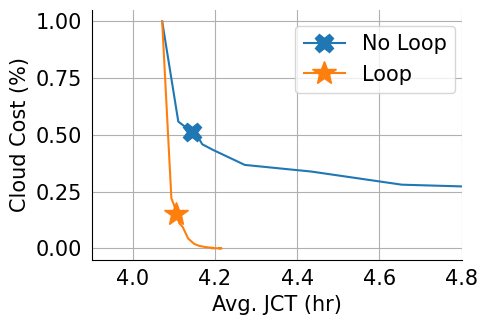

In [281]:
simulator_plotting_fn(loop_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 0,},
                      groupby_values=['waiting_policy', 'loop'],
                      normalize_x_axis=True)

In [118]:
sched_alg_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/sched_alg_pareto.log')

In [282]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    
    super_list = [(idx, label, grp) for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values))]
    super_list = [super_list[1], super_list[2], super_list[0]]
    for idx, label, grp in super_list:
        print(label)
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
            continue
        elif label[0] == 'linear_cost':
            if label[1] == 'fifo':
                label = 'FCFS'
            elif label[1]== 'sjf':
                label = 'SJF'
            elif label[1] == 'edf':
                label = 'EDF'
            else:
                label = 'No'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
#     #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
# #     fig.legend(lines, labels, ncol=len(labels), \
# #                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['sched_alg_x'] == 'fifo' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:blue'
        if row['sched_alg_x'] == 'sjf' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:orange'
        if row['sched_alg_x'] == 'edf' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'P'
            marker_size = 13
            color='tab:green'
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)

            
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='*', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=18, markeredgecolor='tab:blue', label='FSFS'), 
                Line2D([0], [0], marker='X', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='SJF'),
               Line2D([0], [0], marker='P', color='tab:green', markerfacecolor='tab:green', \
            markersize=13, markeredgecolor='tab:green', label='EDF')], labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))            

    plt.tight_layout()
    plt.savefig('figures/evaluation/sched_alg_pareto.pdf', bbox_inches='tight')
    plt.show()  

('linear_cost', 'fifo')
('linear_cost', 'sjf')
('linear_cost', 'edf')


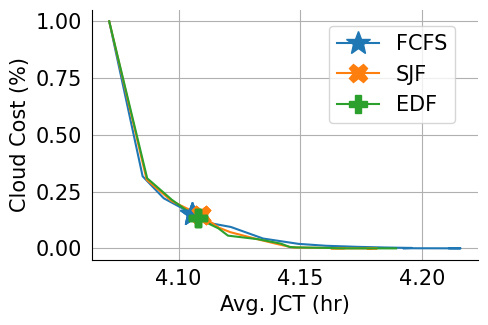

In [283]:
simulator_plotting_fn(sched_alg_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'sched_alg'],
                      normalize_x_axis=True)

In [217]:
binpack_df = utils.load_logs_as_dataframe('/home/gcpuser/starburst_logs/evaluation/binpack_pareto.log')

In [287]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=6)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    
    super_list = [(idx, label, grp) for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values))]
    super_list = [super_list[1], super_list[2], super_list[0]]
    for idx, label, grp in super_list:
        print(label)
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
            continue
        elif label[0] == 'linear_cost':
            if label[1] == 'first-fit':
                label = 'First-Fit'
            elif label[1]== 'best-fit':
                label = 'Best-Fit'
            elif label[1] == 'worst-fit':
                continue
                label = 'Worst-Fit'
            else:
                label = 'No'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
#     #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
# #     fig.legend(lines, labels, ncol=len(labels), \
# #                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['binpack_alg_x'] == 'first-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:blue'
        if row['binpack_alg_x'] == 'best-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:orange'
        if row['sched_alg_x'] == 'worst-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:green'
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='X', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='First-Fit'), 
                Line2D([0], [0], marker='*', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=18, markeredgecolor='tab:orange', label='Best-Fit')], labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/binpack_pareto.pdf', bbox_inches='tight')
    plt.show()  

('linear_cost', 'first-fit')
('linear_cost', 'worst-fit')
('linear_cost', 'best-fit')


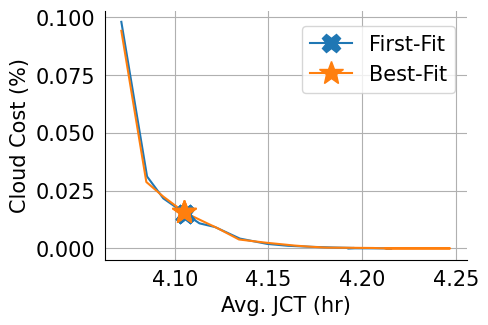

In [288]:
simulator_plotting_fn(binpack_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'binpack_alg'],
                      normalize_x_axis=True)

In [1]:
import pickle
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils
file = open("/home/gcpuser/skyburst/data.pkl",'rb')
job = pickle.load(file)

In [2]:
from skyburst.job import Job
arrival_times = job['arrival']
run_times = job['runtime']
resources = job['num_gpus']
print(np.mean(run_times))
idxs = job['idx']
print(run_times)
lol = zip(arrival_times, run_times, resources)
job_list = []
temp = False
idx=0
for l in sorted(lol):
    if not temp:
        offset = l[0]
        temp=True
    job_list.append(Job(idx=idx, arrival=l[0] - offset, runtime=l[1], resources={'GPUs': l[2]}, cost= l[1]* l[2]))
    idx+=1
print(job_list)

18.054945054945055
[16, 15, 13, 17, 26, 18, 21, 20, 9, 7, 8, 6, 30, 6, 60, 8, 16, 5, 12, 5, 9, 22, 17, 4, 16, 32, 28, 23, 18, 4, 9, 6, 16, 19, 10, 28, 42, 17, 4, 27, 33, 4, 28, 6, 14, 9, 7, 14, 5, 22, 4, 13, 73, 8, 10, 31, 9, 49, 47, 7, 7, 13, 33, 5, 16, 14, 5, 53, 5, 19, 17, 60, 11, 5, 27, 5, 46, 8, 16, 20, 12, 5, 24, 7, 17, 7, 23, 24, 44, 8, 25]
[Job(idx=0, resources={'GPUs': 2, 'CPUs': 0}, arr=0.0, run = 16, deadline=0.0, start=None)
, Job(idx=1, resources={'GPUs': 1, 'CPUs': 0}, arr=2.044724464416504, run = 15, deadline=0.0, start=None)
, Job(idx=2, resources={'GPUs': 4, 'CPUs': 0}, arr=3.995098114013672, run = 13, deadline=0.0, start=None)
, Job(idx=3, resources={'GPUs': 2, 'CPUs': 0}, arr=6.023394584655762, run = 11, deadline=0.0, start=None)
, Job(idx=4, resources={'GPUs': 4, 'CPUs': 0}, arr=8.695385694503784, run = 17, deadline=0.0, start=None)
, Job(idx=5, resources={'GPUs': 1, 'CPUs': 0}, arr=10.699166059494019, run = 5, deadline=0.0, start=None)
, Job(idx=6, resources={'GPUs

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 32307.57it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            constant-2                        1                1262            5.48432        0.526514     18.5815               0.766994               1.31571


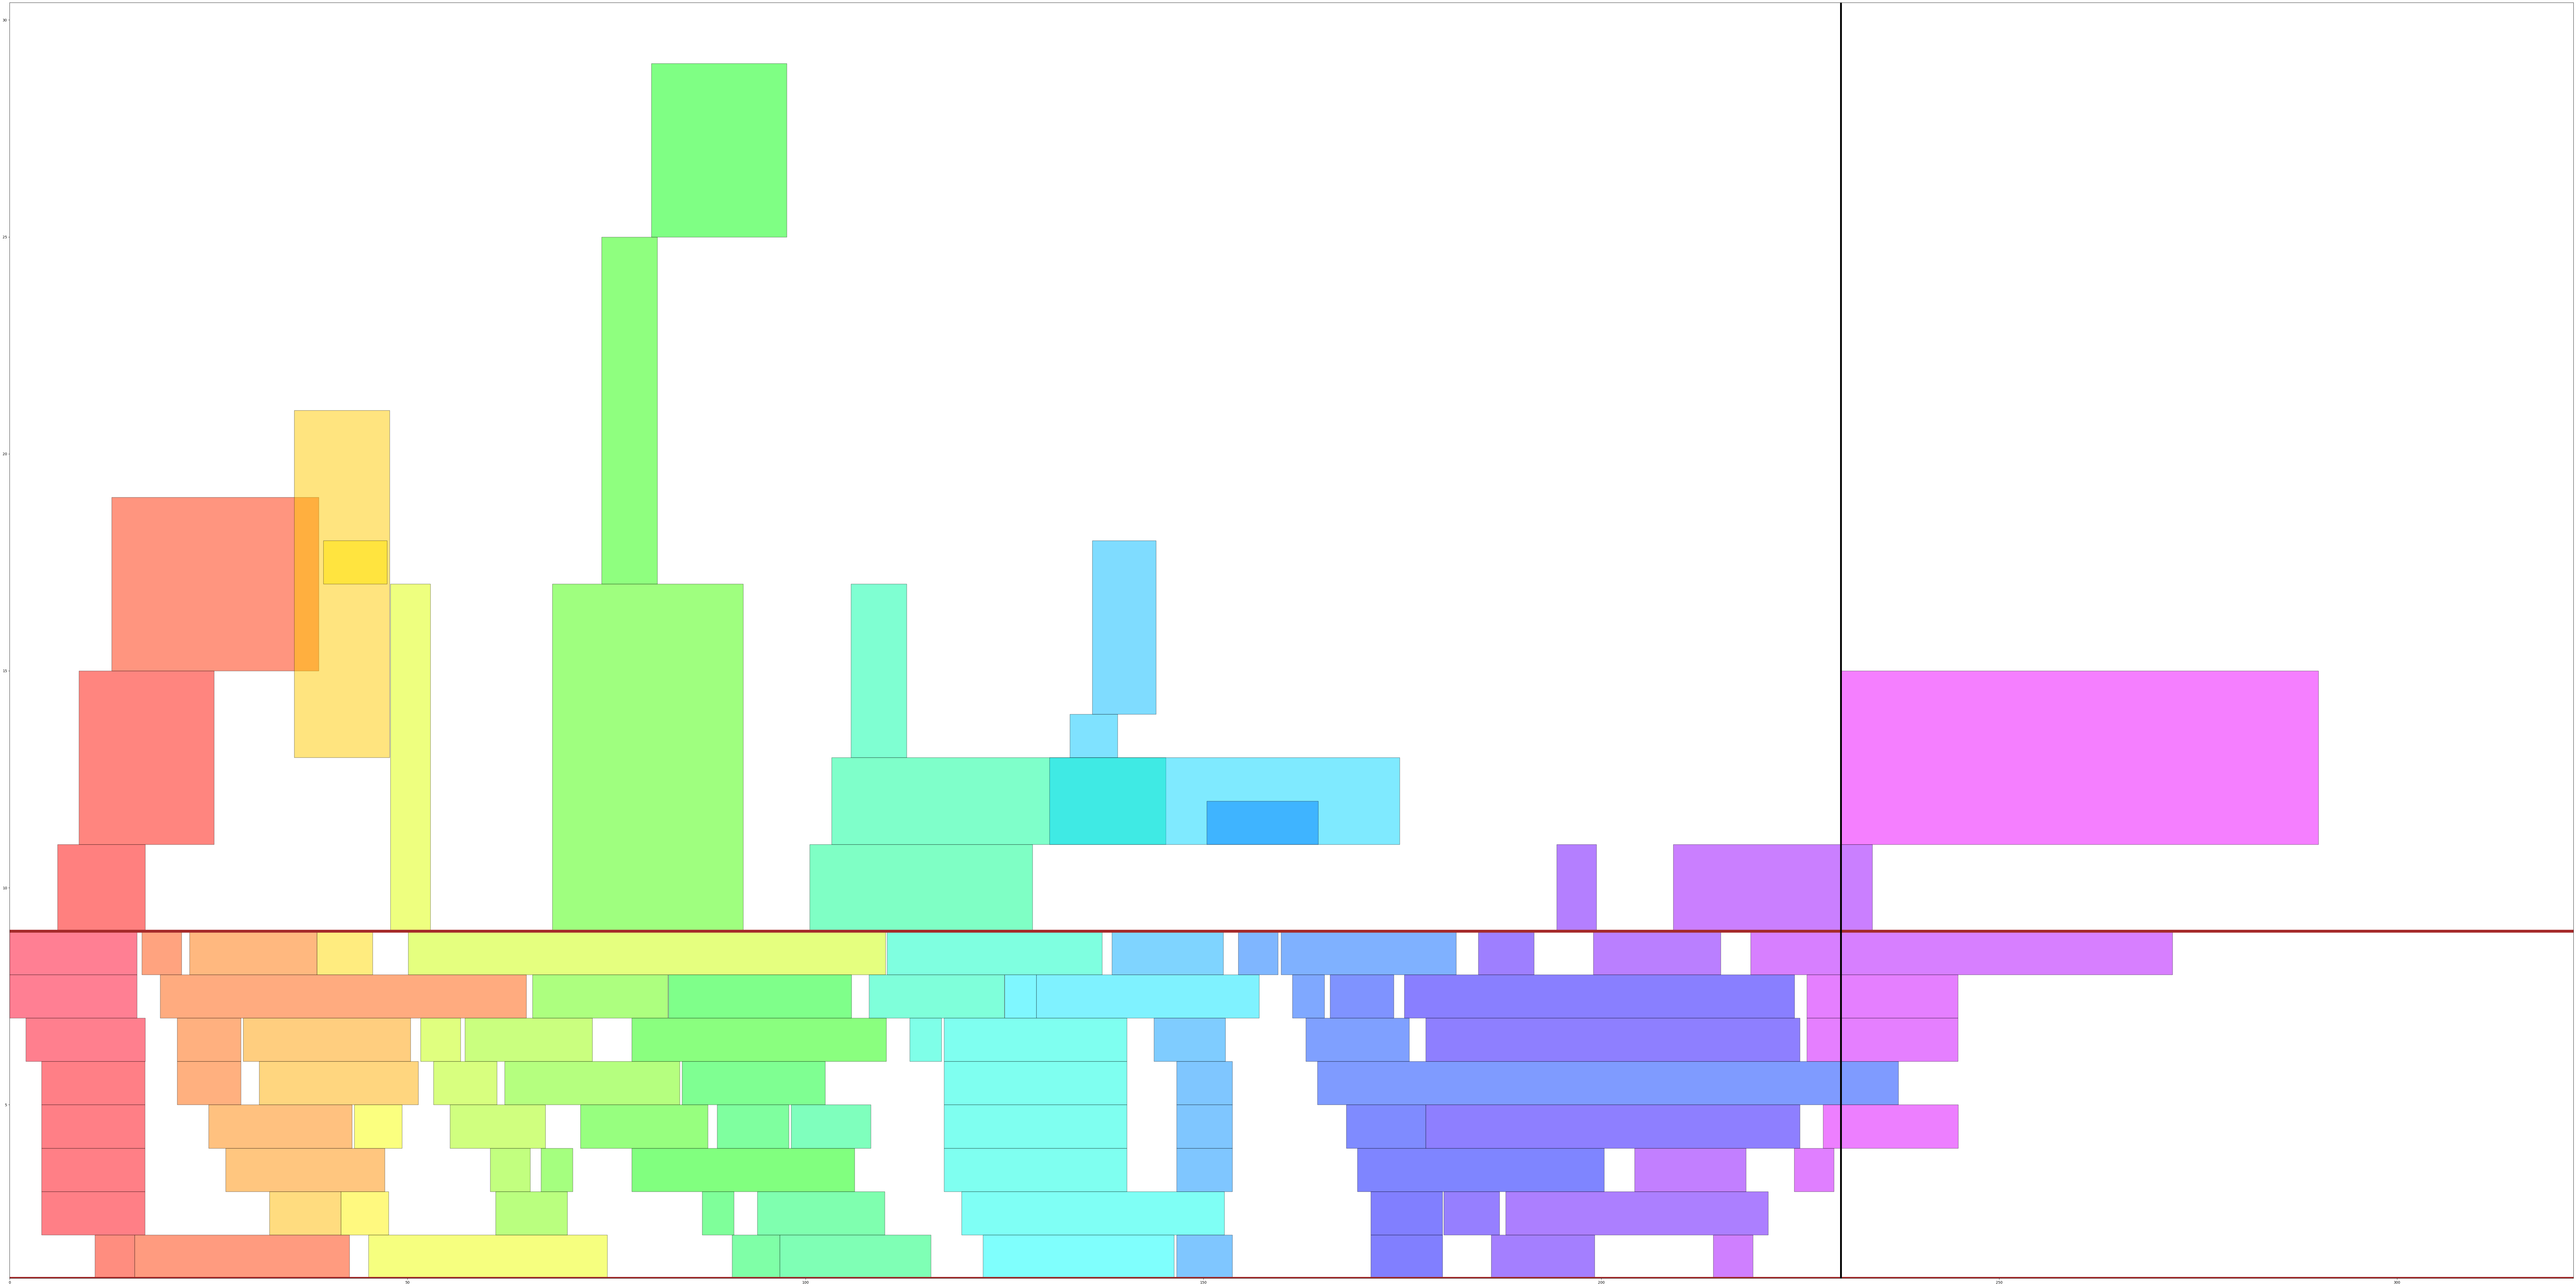

In [3]:
from skyburst.simulator import run_simulator
from skyburst.plot import *

run_config = {
    # Size of the cluster (i.e. # of cluster nodes).
    'cluster_size': 1,
    # Number of GPU(s) per cluster node.
    'gpus_per_node': 8,
    # Number of CPU(s) per cluster node.
    'cpus_per_node': 96,
    # Scheduling algorithm specifying order of the queue.
    'sched_alg': 'fifo',
    # How jobs are binpacked into the cluster.
    'binpack_alg': 'first-fit',
    # Waiting policy (how long jobs should wait in the cloud).
    'waiting_policy': 'constant',
    # Waiting hyperparameter (to be passed to waiting_policy)
    'waiting_factor': 0,
    # Sets clipping time for waiting (max time a job should wait)
    'clip_time': 1e9,
    # Enable backfill (assumes time estimator).
    'backfill': False,
    # Enable loop scheduling (just loop through entire queue, remove HoL).
    'loop': False,
    # Enable prediction. (Jobs predict if they can be assigned to cluster before timing out).
    # 0 is no prediction, 1 is perfect oracle
    'predict_wait': 0,
    # Queue length
    'max_queue_length': -1,
    # Time estimator error
    'time_estimator_error': 0,
    # (Deprecated) Algorithm to immediately send job to cloud (without waiting).
    'filter_alg': None,
    # Prints out simulator state at every timestep.
    'verbose': False,
    # Appends python debugger at every timestemp.
    'debug': False,
    # Position for TQDM progress tracker bar.
    'pbar_idx': 0,
    # Jobs to not consider for final metrics at the beg. and end. of simulator.
    'warmup_jobs': 0,
    # Whether to get snapshots and save to result dict
    'snapshot': False,
    # Metadata on job generation (run prior to simulator).
    'jobgen_spec': {
        # Dataset type ['philly', 'philly_gen', 'gen_gpu']
        'dataset': 'philly',
        # Arrival rate of jobs (used in 'gen_gpu', 'philly_gen')
        'arrival_rate': -1,
        # Total number of jobs generated.
        'total_jobs': -1,
        # Avg. Job runtime (used in 'gen_gpu')
        'job_runtime': -1,
    }
}


run_config['waiting_factor'] = 2
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 35344.17it/s]


Sched Policy    Waiting Policy      # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ----------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            constant-10                       1                1059            4.60214         5.19265     23.2476               0.863859               1.30875


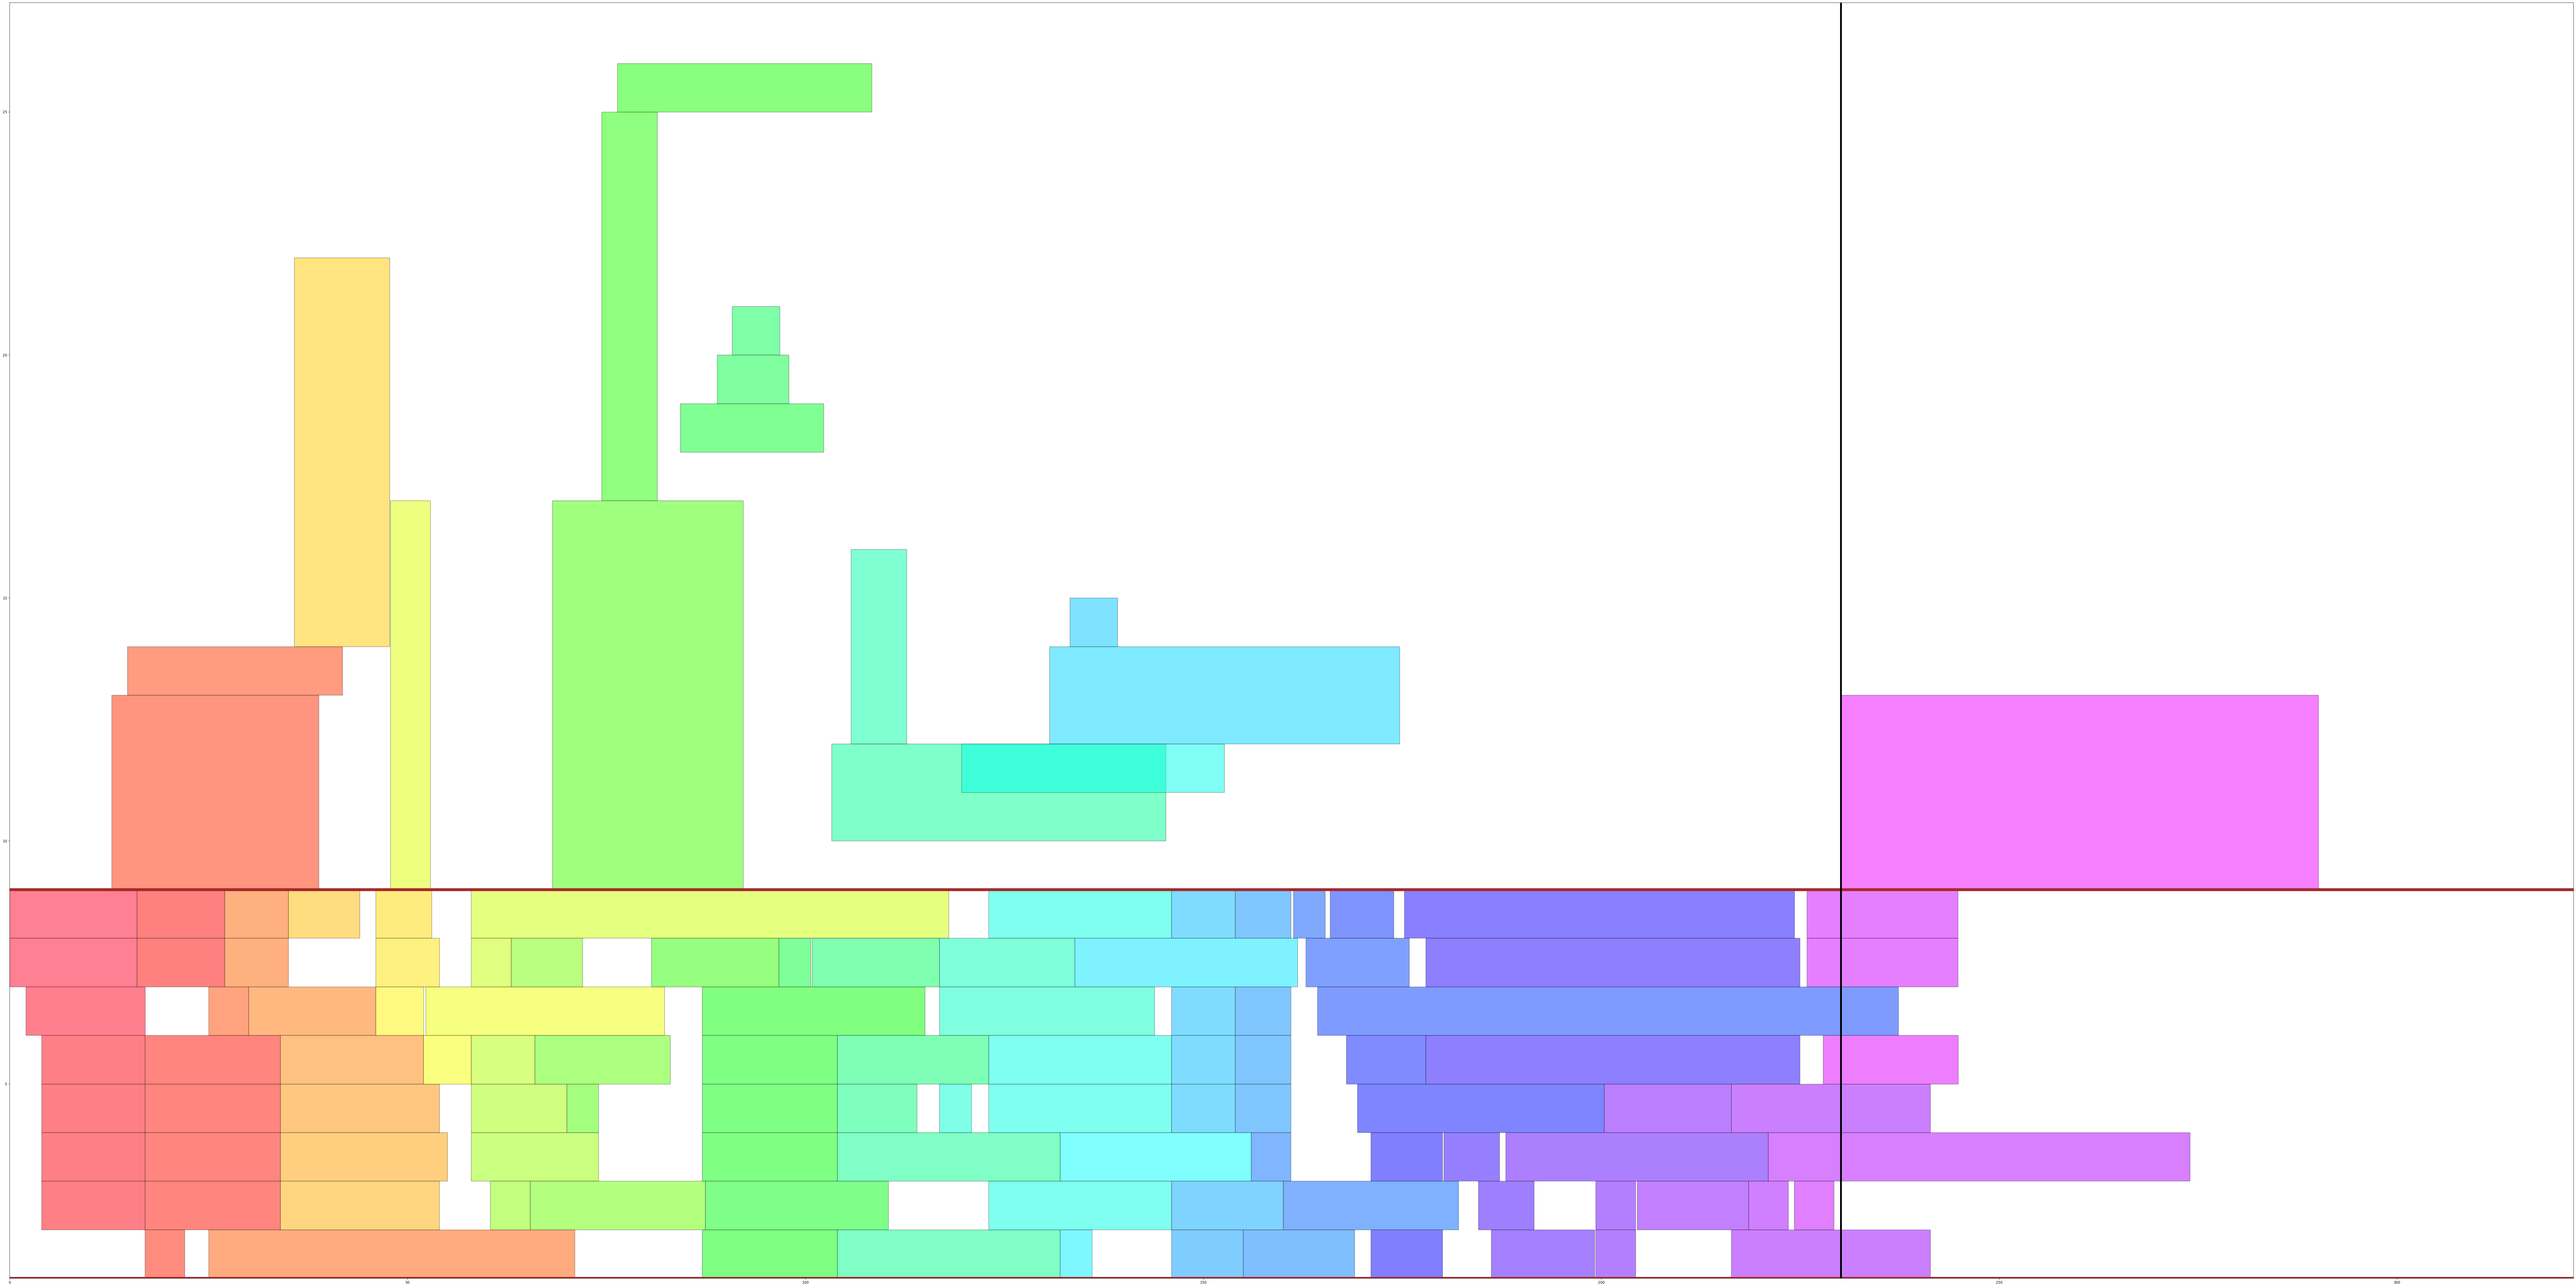

{'idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90]), 'arrival': array([  0.        ,   2.04472446,   3.99509811,   6.02339458,
         8.69538569,  10.69916606,  12.82585788,  14.80480862,
        16.60911655,  18.91407704,  21.0600431 ,  22.61920595,
        25.01416612,  27.13101387,  29.12239146,  31.34432626,
        32.6340456 ,  35.75638676,  37.03053427,  39.43030119,
        41.10754585,  43.15436149,  45.09008741,  47.8527739 ,
        50.07085085,  51.42384219,  53.24070764,  55.32175851,
        57.22092271,  60.39772201,  61.05663681,  62.18464589,
        65.51564145,  66.76047277,  68.17844915,  71.72573853,
      

In [5]:
run_config['waiting_policy'] = 'constant'
run_config['waiting_factor'] = 10
run_config['loop']=0
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)
print(no_wait_results)

Jobs progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 35106.85it/s]


Sched Policy    Waiting Policy                       # Cluster Nodes    Total Cloud Cost    Avg. Cloud Cost    Avg. Waiting    Avg. JCT    Cluster Utilization    System Utilization
--------------  ---------------------------------  -----------------  ------------------  -----------------  --------------  ----------  ---------------------  --------------------
fifo            linear_runtime-1.5882352941176472                  1                 799            3.47225         2.08685     20.1418               0.873754               1.30778


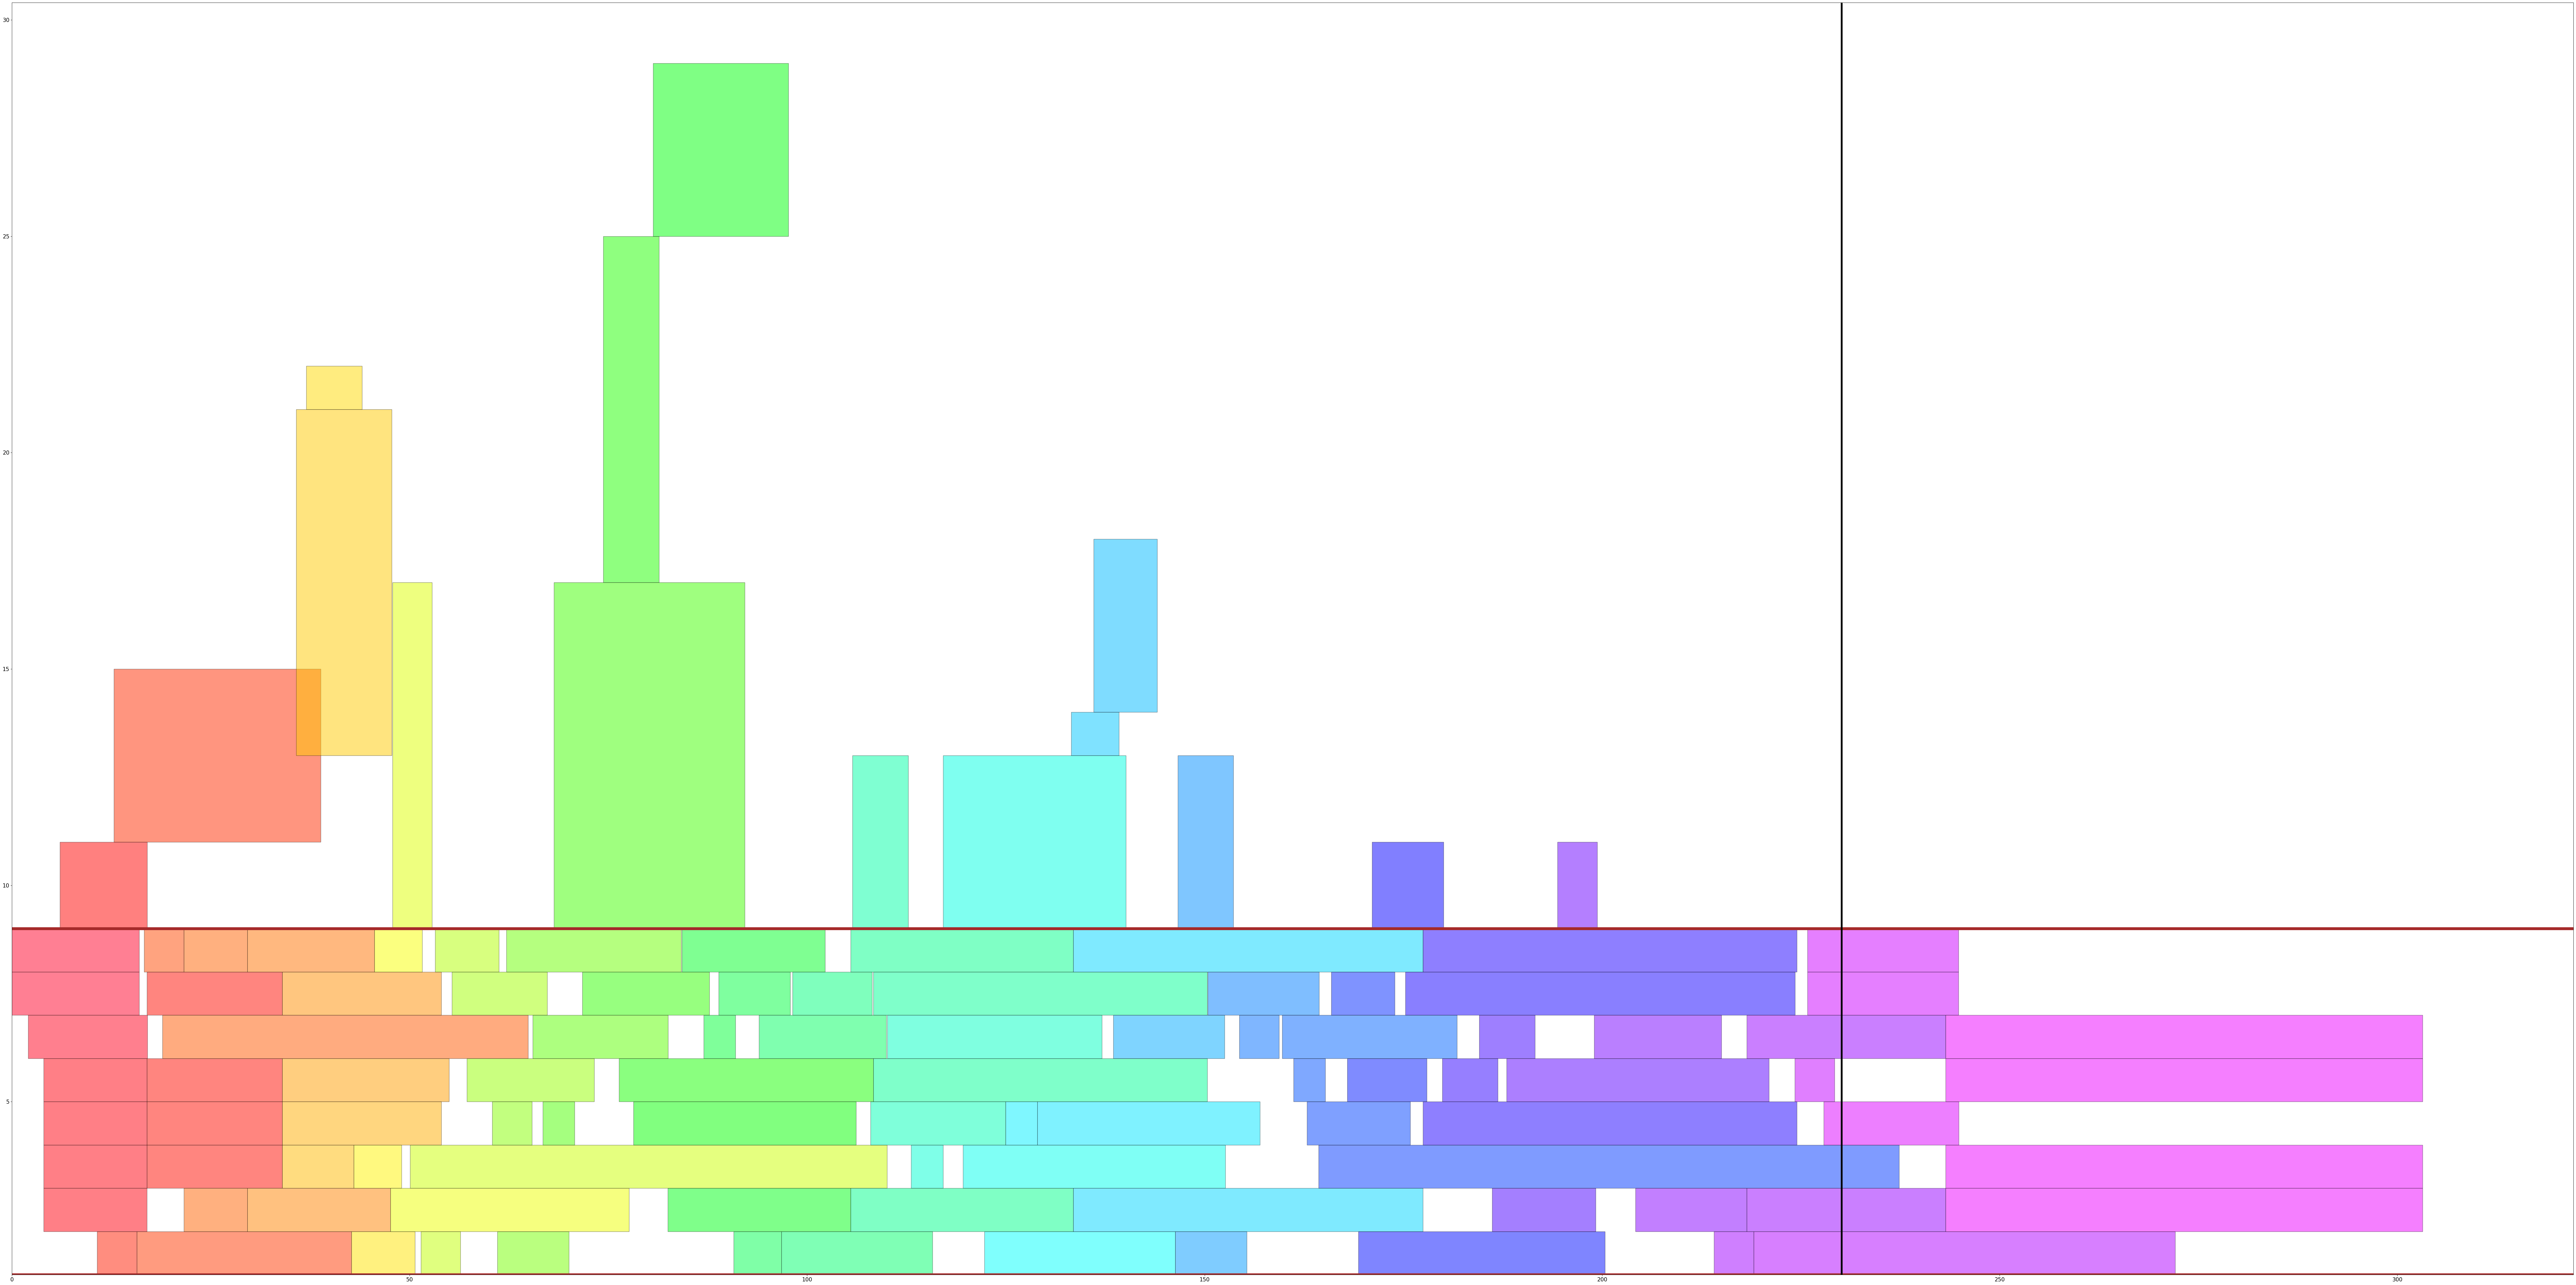

In [53]:
run_config['waiting_policy'] = 'linear_runtime'
run_config['waiting_factor'] = 1 + 10/17
run_config['loop']=1
no_wait_results = run_simulator(job_list, run_config)
plot_trace_spacetime_and_spillover(no_wait_results,1)